<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/SIAM2021_RNNs_Single_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical: Time series prediction
(21/July/2021)

### 2021 Gene Golub SIAM Summer School 
https://sites.google.com/aims.ac.za/g2s3/home 

Instructor

<font color="green">***Dr. Emmanuel Dufourq*** 

www.emmanueldufourq.com

edufourq (['@']) gmail.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2021***

Note: this is a long notebook and hence is split into 4 parts which are initially "hidden".

Material adapted from: https://www.tensorflow.org/tutorials/structured_data/time_series

Code licensed under https://www.apache.org/licenses/LICENSE-2.0



## <font color="green"> Learning outcomes:

* Single feature output (in this example, we output predictions on temperature)

* Single time-step outputs (in this example, we predict temperature 1 hour into the future)

* We will compare linear, fully connected NN, CNN and RNN models.

## <font color="green">Data information:

* Features: 14 real valued features

* Output: 1 real valued label (temperature)

## <font color="green">Tasks for participants (boolean)?

* No, follow along and make your own modifications and make sure you understand


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Weather dataset



This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

We will be working with time series data which orginates from here: https://www.bgc-jena.mpg.de/wetter/ first let's download a snapshot of data from 2009 to 2016. Below we extract the .zip data

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


Now let's read in the .csv data using Pandas.

In [ ]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


# Preprocessing

## Hourly predictions

Slice the data to extract only every 6th record. The original data has one row for every 10 minutes.

In [ ]:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## Visualise all of the data for some variables

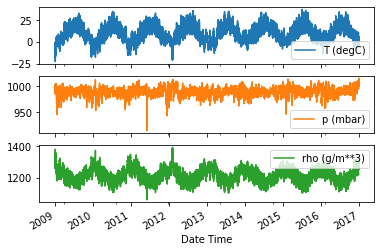

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## Visualise some of the data for some variables

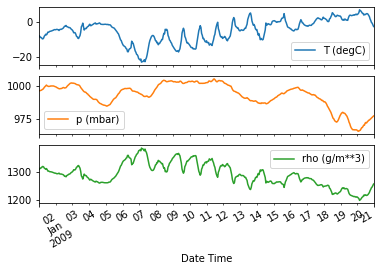

In [ ]:
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Clean up the data

More details available here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

## Split the data into training, validation and testing

We clearly split the data such that the order is preserved and such that each split is disjoint. No random shuffling like for the previous problems.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


## Normalise each split

Note how we are using the mean and sdev from the training data and applying it to the validation and testing!

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


In [ ]:
val_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
294383,0.213759,0.618351,0.597730,1.321003,1.207707,0.407409,1.535799,-0.688716,1.526045,1.526654,-0.601703,0.072253,-0.639008,0.089478,-0.535618,0.759951,1.192787,-0.859306,-1.151853
294389,0.241478,0.545560,0.523229,1.260764,1.286231,0.321636,1.433619,-0.738532,1.424968,1.423369,-0.526259,0.071987,-0.233849,0.079109,-0.188724,1.042768,0.955490,-0.860161,-1.151299
294395,0.258351,0.510898,0.487698,1.249290,1.370796,0.282648,1.414609,-0.784197,1.406250,1.404590,-0.490612,-0.459268,0.629912,-0.526513,0.659056,1.254528,0.653085,-0.861015,-1.150745
294401,0.277634,0.487789,0.463629,1.227776,1.388917,0.256656,1.378964,-0.794575,1.368815,1.367032,-0.463755,-0.086355,-0.297434,-0.068182,-0.229261,1.380799,0.306181,-0.861869,-1.150190
294407,0.294506,0.502810,0.476236,1.255027,1.413079,0.273551,1.424114,-0.807029,1.413738,1.413979,-0.474987,-0.421783,0.109299,-0.413007,0.139150,1.412977,-0.061582,-0.862723,-1.149635


In [ ]:
test_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
378491,1.599724,-0.728855,-0.846438,-0.480418,0.821124,-0.764821,-0.633744,-0.667960,-0.656453,-0.654069,1.089310,1.623820,1.106908,1.557556,1.016688,-1.224696,0.707179,1.262942,0.511342
378497,1.653958,-0.734632,-0.856754,-0.563604,0.615753,-0.767420,-0.700280,-0.613992,-0.720093,-0.719796,1.112016,1.704558,0.855454,1.888362,0.898892,-0.999946,1.000059,1.263298,0.510397
378503,1.684087,-0.768139,-0.892285,-0.593724,0.645954,-0.788214,-0.721666,-0.626446,-0.742555,-0.743270,1.153523,1.660785,1.082109,1.443980,0.911444,-0.707046,1.224794,1.263652,0.509452
378509,1.666010,-0.829376,-0.950739,-0.542091,0.990254,-0.822003,-0.683646,-0.717775,-0.705119,-0.703364,1.205528,1.043796,1.479713,1.060063,1.414679,-0.365957,1.366069,1.264006,0.508506
378515,1.658778,-0.836308,-0.957616,-0.550696,0.990254,-0.827201,-0.690775,-0.717775,-0.712606,-0.710407,1.211876,1.804237,1.284633,1.767462,1.197013,0.000077,1.414255,1.264359,0.507561


## Class to create batches of data

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  
  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) 
  # pairs using the preprocessing.timeseries_dataset_from_array function.
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

## Using the Window Generator

The WindowGenerator allows us to create different input/output pairs so we can train different types of models. The main types are: single step and multi step. In single step we consider 1 input and 1 output. In multi step we consider variable input and output. In the examples below we will use all input features but only 1 output feature, the temperature.

### Single step window

Single step here means one input and one label. This will create pairs of data to train models on a single input and a single output. Also a single feature input and output, in this example temperature.

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

This first task is to predict temperature 1h in the future given the current value of all features. 

<center><img src="https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png">

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The ```.element_spec``` property allows us to take a look at the shapes of the window. Let's take a look below at what the shapes look like which help us decide on the network input. The shapes are in the format: (batch, time, features)

In [ ]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

# Comparing various models

First, let's define a function that will compile and fit any model.

In [ ]:
def compile_and_fit(model, window, patience=2):

  # Early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Compilte the model using MSE and Adam optimiser
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  print (model.summary())

  # Train the model, her for 2 epochs
  history = model.fit(window.train, epochs=2,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Since we will explore various models, let's keep track of each one's performance by creating a dictionary. For each method we will inset the results into the dictionary and keep track of each method's performance on the validation and testing data

In [ ]:
val_performance = {}
performance = {}

## Linear Neural Network

Let's create a linear model.

In [ ]:
linear = tf.keras.Sequential()
linear.add(tf.keras.layers.Dense(units=1,activation='linear', input_shape = (1,19)))

### Fit the linear model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(linear, single_step_window)

# Store the performance results on the validation data
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1534/1534 [==============================] - 15s 9ms/step - loss: 0.1674 - mean_absolute_error: 0.2538 - val_loss: 0.0129 - val_mean_absolute_error: 0.0855
Epoch 2/2
439/439 [==============================] - 3s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0703


### Plot results

If we use the single_step_window the plots are not useful. The plot shows us a single input and the single output. It would be better to show this over a larger number of values than just one.

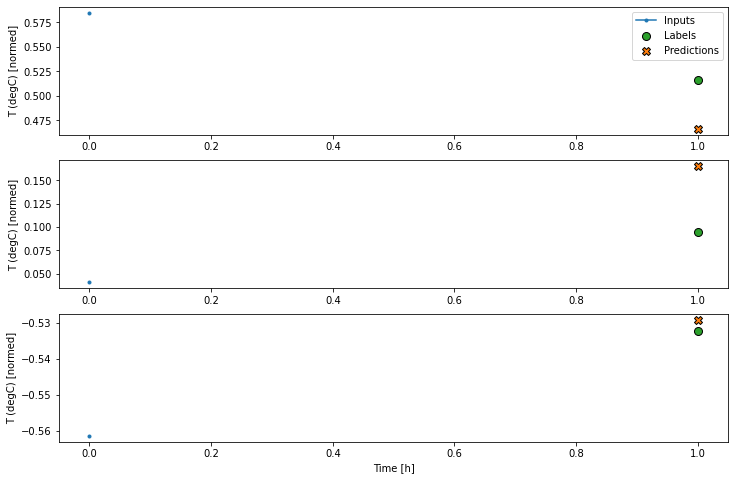

In [ ]:
single_step_window.plot(linear)

Instead, we can create a window of 24 inputs and 24 targets, and then plot those. 

Note: The model only uses a single input and makes a single prediction. But since we have 24 elements we can treat this like a batch and produce more interesting plots. Each prediction is independant and only uses 1 input and produces 1 output.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

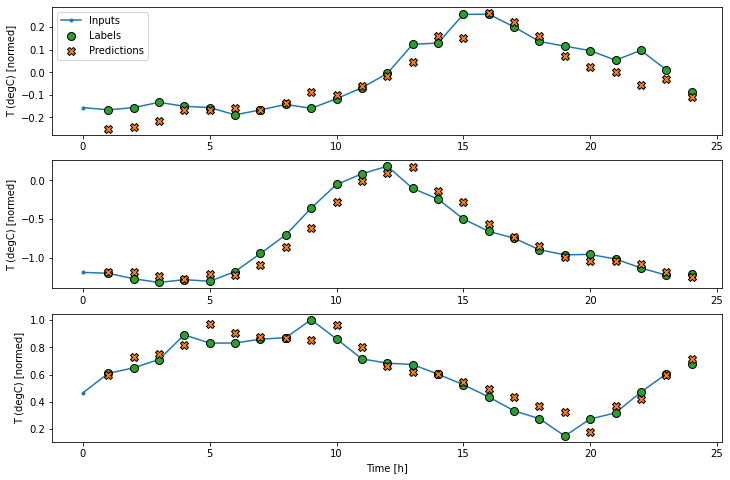

In [ ]:
wide_window.plot(linear)

## Dense model

Let's creat a fully connected model.

In [ ]:
dense = tf.keras.Sequential()
dense.add(tf.keras.layers.Dense(units=64,activation='relu', input_shape = (1,19)))
dense.add(tf.keras.layers.Dense(units=64,activation='relu'))
dense.add(tf.keras.layers.Dense(units=1,activation='linear'))

### Fit the dense model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(dense, single_step_window)

# Store the performance results on the validation data
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 64)             1280      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0148 - mean_absolute_error: 0.0795 - val_loss: 0.0081 - val_mean_absolute_error: 0.0664
Epoch 2/2
439/439 [==============================] - 2s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0613


### Plot the results

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

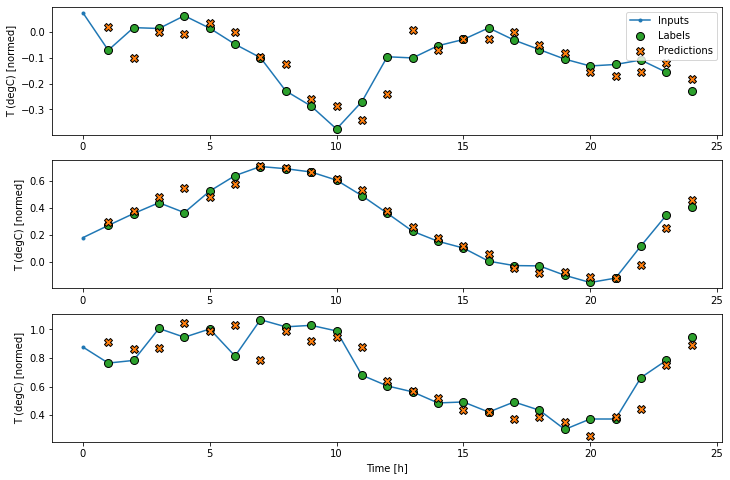

In [ ]:
wide_window.plot(dense)

## CNN model (for multi-time step input)




Let's creat a 1-D convolutional model.

Previous we used 2-D CNNs but we can always make use of 1D CNNs which has the same underlying mechanisms.

In the exampels above we only have 1 input, but surely to make better predictions we should use more time steps.

First, let's create multi time step inputs. This is code you've seen before for plotting, but now we will use it for the model training and make some modifications. Now let's consider 3 time step inputs and 1 label output. In other words, 3 hours of input and predicting 1 hour ahead.

In [ ]:
wide_window = WindowGenerator(
    input_width=3, label_width=1, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

### Create a CNN model

Take note of the kernel size for the convolutional layer. Note the input shape is now (3,19) as we have 3 time steps and 19 features. In our case we have create a kernel size of (3,) meaning the CNN layer will read in 3 input and apply the convolutional operation on those 3 values.

In [ ]:
conv_model = tf.keras.Sequential()
conv_model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=(3,) ,activation='relu',input_shape = (3,19))) 
conv_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
conv_model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

### Fit the dense model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(conv_model, wide_window)

# Store the performance results on the validation data
val_performance['Conv1d'] = conv_model.evaluate(wide_window.val)
performance['Conv1d'] = conv_model.evaluate(wide_window.test, verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             1856      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0181 - mean_absolute_error: 0.0914 - val_loss: 0.0087 - val_mean_absolute_error: 0.0701
Epoch 2/2
438/438 [==============================] - 2s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0609


### Plot the results

A slight adjustment for plotting is required here. Since our model takes 3 inputs to make 1 prediction, we need to change the parameters below so that the first input will be [0, 1, 2] to produce the output index [3]. And so on...

In [ ]:
LABEL_WIDTH = 24
CONV_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

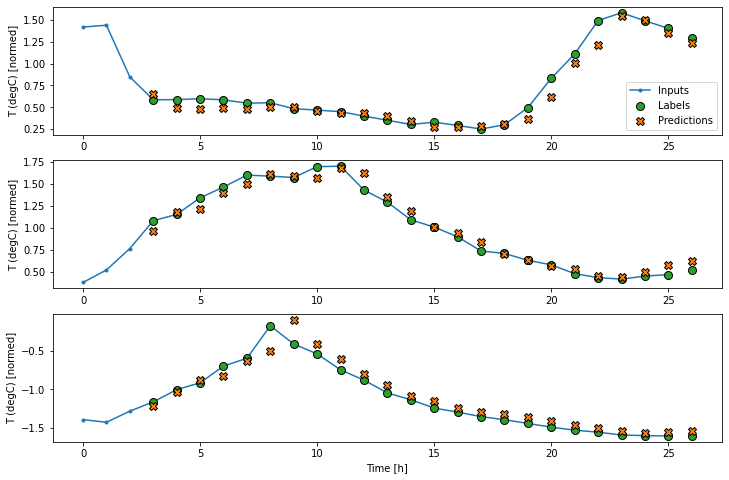

In [ ]:
wide_conv_window.plot(conv_model)

## RNNS

First, let's create multi time step inputs. This is code you've seen before for plotting, but now we will use it for the model training and make some modifications. Now let's consider 24 time step inputs and 24 label outputs. Even though we create 24 hour outputs it doesn't mean we will predict 24 hours ahead. In this example we will train on 24 hours of data but only predict 1 hour ahead.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

### Create a RNN model

Some differences here.

* Input shape

* ```return_sequences``` arguement

Note the input shape of (24,19). We take in 24 time steps and 19 features as input. We have 1 unit output since we are predicting 1 hour ahead.

We set ```return_sequences=True``` so that the model can make a prediction for each of the 24 inputs. This is useful if you want to stack RNN layers as each RNN layer will produce 24 outputs for each unit. Look at the summary below you will see (24,32).

If you set ```return_sequences=False``` then the model only makes a prediction for the very last label. This gives the model a chance to 'warmup' the internal cell state.

<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png">

If you set ```return_sequences=True``` then there will be a prediction for each time stamp

<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png">



In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=32,activation='relu',input_shape = (24,19), return_sequences=True))
lstm_model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

### Fit the RNN model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(lstm_model, wide_window)

# Store the performance results on the validation data
val_performance['lstm_model'] = lstm_model.evaluate(wide_window.val)
performance['lstm_model'] = lstm_model.evaluate(wide_window.test, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            6656      
_________________________________________________________________
dense_6 (Dense)              (None, 24, 1)             33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1533/1533 [==============================] - 25s 15ms/step - loss: 0.0267 - mean_absolute_error: 0.0917 - val_loss: 0.0068 - val_mean_absolute_error: 0.0577
Epoch 2/2
438/438 [==============================] - 3s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0546


### Plot the results

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

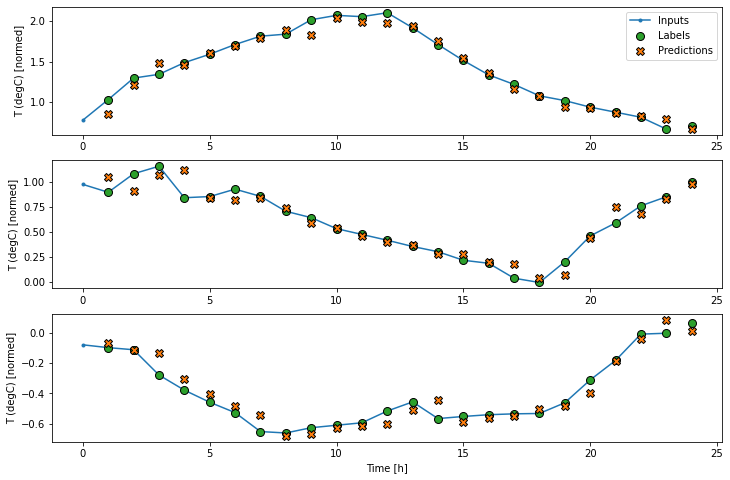

In [ ]:
wide_window.plot(lstm_model)

### Stacked RNN model

In [ ]:
stacked_lstm_model = tf.keras.Sequential()
stacked_lstm_model.add(tf.keras.layers.LSTM(units=24,activation='relu',input_shape = (24,19), return_sequences=True))
stacked_lstm_model.add(tf.keras.layers.LSTM(units=16,activation='relu', return_sequences=True))
stacked_lstm_model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

### Fit a stacked RNN model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(stacked_lstm_model, wide_window)

# Store the performance results on the validation data
val_performance['stacked_lstm_model'] = stacked_lstm_model.evaluate(wide_window.val)
performance['stacked_lstm_model'] = stacked_lstm_model.evaluate(wide_window.test, verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 24)            4224      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 16)            2624      
_________________________________________________________________
dense_7 (Dense)              (None, 24, 1)             17        
Total params: 6,865
Trainable params: 6,865
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1533/1533 [==============================] - 44s 26ms/step - loss: 0.0329 - mean_absolute_error: 0.1009 - val_loss: 0.0071 - val_mean_absolute_error: 0.0591
Epoch 2/2
438/438 [==============================] - 4s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0542


### Plot the results

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

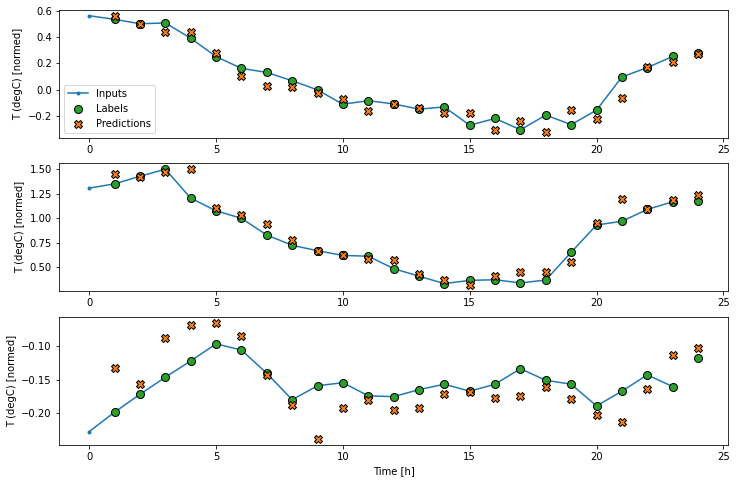

In [ ]:
wide_window.plot(stacked_lstm_model)

# Final Performance

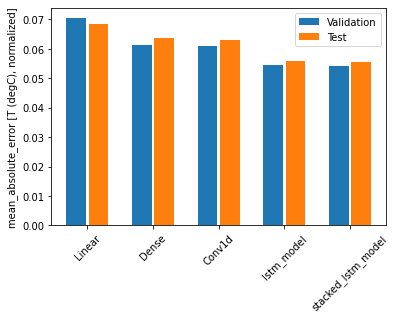

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = stacked_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
